The followings are packages we use.
<div hidden>
$\def\T{{\scriptscriptstyle\mathsf{T}}}$
$\newcommand{\ip}[2]{\left\langle #1, #2 \right \rangle}$

In [1]:
import ogb
from ogb.linkproppred import LinkPropPredDataset

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#the following is for the "ogbl-ddi" data (representing drug-drug interactions)
dataset = LinkPropPredDataset(name = "ogbl-ddi")

#the following is for the "ogbl-biokg" data (note: heterogenous and directed)
#dataset = LinkPropPredDataset(name = "ogbl-biokg")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from numpy import genfromtxt
import scipy.sparse as sp
import math
import copy
import random
import ast
import sys
import time
import csv
# import torch

# from torch_geometric.data import Data
# from torch_geometric.utils.convert import to_networkx, from_networkx
from IPython.display import display, Markdown

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
A = np.zeros((4039, 4039))
f = open("facebook_combined.txt", 'r')
while True:
    line = f.readline()
    if not line: break
    edge_string = line.split()
    edge = np.array(list(map(int,edge_string))) 
    A[edge[0], edge[1]] = 1
f.close()

A = np.maximum(A, A.T)
print(np.count_nonzero(A))

176468


In [17]:
'''Dataset import from Open Graph Benchmark: https://ogb.stanford.edu/'''
graph = dataset[0] # pyg graph object containing only training edges
print(type(graph))
print(graph)
num_nodes = graph["num_nodes"]
# print(num_nodes)
raw_mat = np.array(graph["edge_index"])
# print(np.size(raw_mat))

arr_from = raw_mat[0, :]
arr_to = raw_mat[1, :]
length = num_nodes
A = np.zeros((num_nodes, num_nodes))

for idx in range(len(arr_from)):
    A[arr_from[idx]][arr_to[idx]] = 1

print(np.count_nonzero(A))

# G = to_networkx(graph, graph_attrs="edge_index")
# A = nx.adjacency_matrix(G).toarray()
# print(A)
# plt.figure(1,figsize=(14,12)) 
# nx.draw(G, node_color = node_labels, node_size=75,linewidths=6)
# plt.show()

# ### set i as an arbitrary index
# graph = dataset[0] # graph: library-agnostic graph object
# print(graph)
# print(graph["num_nodes"])
# print(np.log(graph["num_nodes"]))
# print(train_edge)

<class 'dict'>
{'edge_index': array([[4039, 2424, 4039, ...,  338,  835, 3554],
       [2424, 4039,  225, ...,  708, 3554,  835]]), 'edge_feat': None, 'node_feat': None, 'num_nodes': 4267}
2135822


In [21]:
#For the "ogbl-biokg" data,
# graph['num_nodes_dict']
# graph['edge_index_dict'][('disease',
#   'disease-protein',
#   'protein')].shape
# graph['num_nodes_dict'].items()
# graph['edge_reltype'].keys()

#Reduce the size of the graph
# graph = dataset[0] # pyg graph object containing only training edges

# # Offsets
# offset_dict = {}
# prefix = 0
# for key, num in graph['num_nodes_dict'].items():
#     if (key not in ('drug', 'protein')):
#         continue
#     offset_dict[key] = prefix
#     prefix += num
    
# print(offset_dict)

# num_nodes = prefix

# # Filling
    
# print(prefix)

# A = np.zeros((prefix, prefix))

# for edge_key in graph['edge_reltype'].keys():
#     if edge_key[0] not in ('drug', 'protein') or edge_key[2] not in ('drug', 'protein'):
#         continue

#     raw_mat = np.array(graph["edge_index_dict"][edge_key])
#     arr_from = raw_mat[0, :]
#     arr_to = raw_mat[1, :]
    
#     head_idx = raw_mat[0, :] + offset_dict[edge_key[0]]
#     tail_idx = raw_mat[1, :] + offset_dict[edge_key[2]]
    
#     A[head_idx, tail_idx] = 1
    
# print(np.count_nonzero(A))

# A_big = A
'''We deal with A_small for the "ogbl-biokg" dataset'''
# range_start1 = 23000
# range_end1 = 24500

# range_start2 = 13000
# range_end2 = 14500
# submatrix_range1 = np.arange(range_start1, range_end1)
# submatrix_range2 = np.arange(range_start2, range_end2)

# A_small = A_big[range_start1:range_end1, range_start2:range_end2]
# A_small2 = A_big[np.ix_(submatrix_range1, submatrix_range2)]
# for x in range(range_end1 - range_start1):
#     A_small2[x][x] = 0.5

# num_nodes = A_small.shape[1]
# print(num_nodes)

# A_small = A_small.T @ A_small

# plt.matshow(A_small)
# plt.show()
# plt.matshow(A_small2)
# plt.show()

'We deal with A_small for the "ogbl-biokg" dataset'

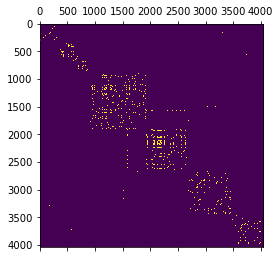

In [14]:
plt.matshow(A)

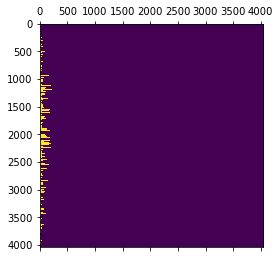

In [15]:
n = A.shape[1]
A_sort = np.zeros((n, n))
for l in np.arange(n):
    A_sort[l, :] = np.sort(A[l, :])[::-1]
plt.matshow(A_sort)

The followings are the implementations for getting the true leading singular vector as well as top-$k$ entries (as well as node indices) in the vector.

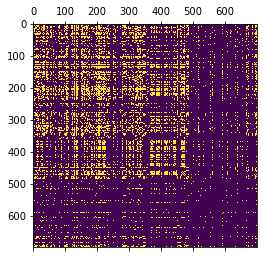

In [9]:
A_big = A

range_start = 900
range_end = 1600
submatrix_range = np.arange(range_start,range_end)

A_small = A_big[np.ix_(submatrix_range,submatrix_range)]

plt.matshow(A_small)
plt.show()

The followings are basic functions that we need for algorithm designs.

In [16]:
#Function that outputs the principal eigenvector & the largest singular value
def numpy_sigrs(A_mat):
    '''True leading singular values & the corresponding singular vector computation'''
    
    U, S, Vt = np.linalg.svd(A_mat, full_matrices=False)

    idx = np.absolute(S).argsort()[::-1]
    # sort the index in a decreasing order of singular values
    sigrvals = S[idx]
    sigrvecs = Vt[idx, :]
    
    sigrval_max = sigrvals[0]
    sigrvec_max = sigrvecs[0, :].T # the top singular vector with column vector form
    
    return sigrval_max, sigrvec_max

def topk_sigrs_calc(sigrvec, k):
    '''Getting top-k entries as well as their node indices of the top-singular vector'''

    desc_sigrvec = np.sort(np.absolute(sigrvec))[::-1]
    topk_sigrvec = np.array(desc_sigrvec)[: k]
    
    desc_idx = np.absolute(sigrvec).argsort()[::-1]
    topk_idx =  np.array(desc_idx)[: k]
    
    return topk_sigrvec, topk_idx

The following is the function for computing (1) the angle difference and (2) the norm difference between the estimated top singular vector and the true one.

In [17]:
def compute_err(sigrvec1, sigrvec2, A_mat):
    '''(1) angle difference and (2) norm difference between two singular vectors sigrvec1 and sigrvec2'''
    
    cosine1 = np.dot(sigrvec1, sigrvec2)/(np.linalg.norm(sigrvec1)*np.linalg.norm(sigrvec2))
    sigrvec1_flip = [x * (-1) for x in sigrvec1]
    cosine2 = np.dot(sigrvec1_flip,sigrvec2)/(np.linalg.norm(sigrvec1)*np.linalg.norm(sigrvec2))
    cosine = max(cosine1, cosine2)
    angle = np.arccos(cosine)
    
    norm_diff1 = np.linalg.norm(np.multiply(cosine, sigrvec1) - sigrvec2)
    norm_diff2 = np.linalg.norm(np.multiply(cosine, sigrvec1_flip) - sigrvec2)
    norm_diff = min(norm_diff1, norm_diff2)
    
    '''projection onto A'''
    
    sigrvec1_new = A_mat @ sigrvec1
    sigrvec1_proj = sigrvec1_new / np.linalg.norm(sigrvec1_new)
    sigrvec1_flip_proj = [x * (-1) for x in sigrvec1_proj]
    
    sigrvec2_new = A_mat @ sigrvec2
    sigrvec2_proj = sigrvec2_new / np.linalg.norm(sigrvec2_new)
    
    cosine1_new = np.dot(sigrvec1_proj, sigrvec2_proj)/(np.linalg.norm(sigrvec1_proj)*np.linalg.norm(sigrvec2_proj))
    cosine2_new = np.dot(sigrvec1_flip_proj, sigrvec2_proj)/(np.linalg.norm(sigrvec1_proj)*np.linalg.norm(sigrvec2_proj))
    cosine_new = max(cosine1_new, cosine2_new)
    
    norm_diff1_proj = np.linalg.norm(sigrvec1_proj - np.multiply(cosine_new,  sigrvec2_proj))
    norm_diff2_proj = np.linalg.norm(sigrvec1_flip_proj - np.multiply(cosine_new,  sigrvec2_proj))
    norm_diff_proj = min(norm_diff1_proj, norm_diff2_proj)

    return angle, norm_diff, norm_diff_proj
    '''return two arrays (1) cosine error and (2) norm difference repsectively'''
    
def compute_topk_err(eigvec, eigvec_true, k):
    '''norm difference between two singular vectors sigrvec1 and sigrvec2'''
    
    desc_eigvec_true = np.sort(np.absolute(eigvec_true))[::-1]
    topk_eigvec_true = np.array(desc_eigvec_true)[: k]
    
    desc_idx = np.absolute(eigvec_true).argsort()[::-1]
    topk_idx =  np.array(desc_idx)[: k]
    topk_eigvec = []
    
    for idx in topk_idx:
        topk_eigvec.append(eigvec[idx])
    topk_eigvec = np.array(topk_eigvec)
    topk_eigvec_flip = [x * (-1) for x in topk_eigvec]
    
    cosine1 = np.dot(topk_eigvec, topk_eigvec_true)/(np.linalg.norm(topk_eigvec)*np.linalg.norm(topk_eigvec_true))
    cosine2 = np.dot(topk_eigvec_flip, topk_eigvec_true)/(np.linalg.norm(topk_eigvec_flip)*np.linalg.norm(topk_eigvec_true))
    cosine = max(cosine1, cosine2)
    
    norm_diff1 = np.linalg.norm(np.multiply(cosine, topk_eigvec) - topk_eigvec_true)
    norm_diff2 = np.linalg.norm(np.multiply(cosine, topk_eigvec_flip) - topk_eigvec_true)
    norm_diff = min(norm_diff1, norm_diff2)

    return norm_diff
    
def compute_err2(sigrvec1, sigrvec2, A_mat):
    '''(1) angle difference and (2) norm difference between two singular vectors sigrvec1 and sigrvec2'''
    
    cosine1 = np.dot(sigrvec1,sigrvec2)/(np.linalg.norm(sigrvec1)*np.linalg.norm(sigrvec2))
    sigrvec1_flip = [x * (-1) for x in sigrvec1]
    cosine2 = np.dot(sigrvec1_flip,sigrvec2)/(np.linalg.norm(sigrvec1)*np.linalg.norm(sigrvec2))
    cosine = max(cosine1, cosine2)
    angle = np.arccos(cosine)
    
    norm_diff1 = np.linalg.norm(sigrvec1 - sigrvec2)
    norm_diff2 = np.linalg.norm(sigrvec1_flip - sigrvec2)
    norm_diff = min(norm_diff1, norm_diff2)
    
    sigrvec1_new = A_mat @ sigrvec1
    sigrvec1_proj = sigrvec1_new / np.linalg.norm(sigrvec1_new)
    sigrvec1_flip_proj = [x * (-1) for x in sigrvec1_proj]
    
    sigrvec2_new = A_mat @ sigrvec2
    sigrvec2_proj = sigrvec2_new / np.linalg.norm(sigrvec2_new)
    
    norm_diff1_proj = np.linalg.norm(sigrvec1_proj - sigrvec2_proj)
    norm_diff2_proj = np.linalg.norm(sigrvec1_flip_proj - sigrvec2_proj)
    norm_diff_proj = min(norm_diff1_proj, norm_diff2_proj)

    return angle, norm_diff, norm_diff_proj
    '''return two arrays (1) cosine error and (2) norm difference repsectively'''

In [18]:
def isSymmetric(A_mat):
    A_mat = np.array(A_mat)
    n = A_mat.shape[1]
    for i in range(n):
        for j in range(n):
            if (A_mat[i][j] != A_mat[j][i]):
                return False
    return True
   
# Driver code
mat = [ [ 1, 3, 5 ], [ 3, 2, 4 ], [ 5, 4, 1 ] ]
if (isSymmetric(mat)):
    print("Yes")
else:
    print("No")
    
print(isSymmetric(mat))

Yes
True


The following is the code for computing Jaccard similarity between two vectors.

In [19]:
def jaccard_similarity(vec1, vec2):
    A = set(vec1)
    B = set(vec2)
    #Find intersection of two sets
    nominator = A.intersection(B)

    #Find union of two sets
    denominator = A.union(B)

    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    return similarity

The followings are the codes for implementing the simple moving average and the exponential weight moving average.

In [20]:
#Simple moving average
def moving_average(arr, window_size):
    
    i=0
    moving_averages = []

    #consider every window of size 3
    while i < len(arr) - window_size + 1:

        # Calculate the average of current window
        window_average = round(np.sum(arr[
          i:i+window_size]) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
    
    result = np.array(moving_averages)
    return result

#Exponential moving average
def exp_moving_average(arr, window_size):
    
    x=0.5  # smoothening factor
    i = 1
    # Initialize an empty list to
    # store exponential moving averages
    moving_averages = []

    # Insert first exponential average in the list
    moving_averages.append(arr[0])

    while i < len(arr):

        # Calculate the exponential
        # average by using the formula
        window_average = (x*arr[i]) + (1-x)*moving_averages[-1]

        # Store the cumulative average
        # of current window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
        
    result = np.array(moving_averages)
    return result

The following is the basic power method that will serve as a baseline.

In [21]:
def basic_PM(A_mat, num_iter):
    '''Basic Power Method, serving as a baseline'''
    
    n = A_mat.shape[1] # number of nodes
    sigrvec = np.random.rand(n).T # generate of an initial random vector
    sigrvec /= np.linalg.norm(sigrvec) # normalize the norm to 1
    
    for num in range(num_iter):
        sigrvec_new = A_mat @ sigrvec
        sigrvec_new /= np.linalg.norm(sigrvec_new)
        
        sigrvec = sigrvec_new     

    # IS: Not sure if this works for top eigenvalue, numerator should be x^T*A*x
    sigrval_max = np.sqrt((A_mat @ sigrvec).T @ (A_mat @ sigrvec) / (sigrvec.T @ sigrvec))
    
    return sigrval_max, sigrvec

Now we present the non-adaptive sampling power method (with a budget constraint) that will serve as another baseline.

In [22]:
def non_adaptive_sampling(A_mat, budget):
    '''Non adaptive sampling method, that first samples n*log^2(n) samples in total and perfrom svd.
This also serves as abaseline'''
    n = A_mat.shape[1]
    num_sample = min(budget, n ** 2)
    
    A_mask = np.zeros((A_mat.shape[0], A_mat.shape[1]))
#     sample_idx_list = random.sample(range(n ** 2), num_sample)

    # IS: changed replace to False
    sample_idx_list = list(np.random.choice(np.arange(n ** 2), size=num_sample, replace = False))
    q_list = []
    mod_list = []
    
    for idx in sample_idx_list:
        q = idx // n
        mod = idx % n
        
        q_list.append(q)
        mod_list.append(mod)
    
    for num in range(len(q_list)):
        i = q_list[num]
        j = mod_list[num]
        A_mask[i][j] += 1
    
    A_new = np.multiply(A_mask, A_mat)
    
#     print("Number of sampled entries for non-adaptive sampling", A_mask.sum())
#     print("Number of sampled 1s for non-adaptive sampling", np.count_nonzero(A_new))
    
    #get the top eigenvector
    sigrval_max, sigrvec_max = basic_PM(A_new, 5)
    
    return sigrval_max, sigrvec_max, A_new

Now we present our scheme Adaptive Power Method (APM) (Algorithm 1) and Adaptive Power Method with Variance Minimization (Algorithm 2).

In [23]:
def APM(A_mat, budget, num_iter):
    '''Algorithm 1: Adaptive Power Method (APM)'''
    '''Budget is only met in expectation, but it's usually pretty close'''
    
    n = A_mat.shape[1]
    
    samples_per_iter = budget/num_iter

    cur_vec = np.random.rand(n).T # initial random vector
    cur_vec /= np.linalg.norm(cur_vec) # normalize the norm to 1
    cur_samples = 0
    
    sampled_entry_row = np.zeros(n)

    prev_samples = np.zeros((A_mat.shape[0], A_mat.shape[1]))
    c = 0.00001 #small constant
    threshold = c/np.sqrt(n*np.log(n))
    eps = 1e-5

    for num in range(num_iter):
        # update the sampling probability
        unsampled = np.ones(A_mat.shape) - prev_samples
        exp_samples = np.sum(np.multiply(unsampled, cur_vec ** 2)) # expected number of new samples with no scaling
        if exp_samples != 0:
            scaling_const = samples_per_iter/exp_samples # scaling constant to get the right number of samples per iteration
        else:
            scaling_const = samples_per_iter

        sampling_prob_matrix = np.multiply(unsampled, cur_vec ** 2)
        sampling_prob_matrix = np.minimum(np.multiply(sampling_prob_matrix, scaling_const), np.ones([n,n]))

        # entry-wise multiplication by 1/samping_prob[j]
        indices = sampling_prob_matrix > eps
        A_mod = np.empty_like(A_mat)
        A_mod[:] = A_mat
        A_mod[indices] /= sampling_prob_matrix[indices]
#         A_mod = np.divide(A_mat, sampling_prob_matrix, where=sampling_prob_matrix!=0, casting='unsafe')
        A_mod = np.multiply(A_mod, unsampled)
        
        #set each entry to be zero if the sampling prob. < threshold
        for idx1 in range(n):
            for idx2 in range(n):
                if sampling_prob_matrix[idx1][idx2] < threshold:
                    A_mod[idx1, idx2] = 0

        A_mask = (np.random.random(A_mat.shape) < sampling_prob_matrix).astype(int)
        
#         for idx in range(n):
#             sampled_entry_row[idx] = np.count_nonzero(A_mask[idx,:])
        
#         print("Minimum number of samples per row", min(sampled_entry_row))
#         print("Maximum number of samples per row", max(sampled_entry_row))
#         print("Mean number of samples per row", np.mean(sampled_entry_row))
#         print("Variance of the number of samples per row", np.var(sampled_entry_row))
        
        cur_samples += np.count_nonzero(A_mask)

        A_new = np.multiply(A_mod, A_mask)
        A_cur = np.multiply(prev_samples, A_mat) + A_new

        prev_samples = prev_samples + A_mask
#         prev_samples = np.maximum(prev_samples, A_mask)

        cur_vec = A_cur @ cur_vec
        cur_vec /= np.linalg.norm(cur_vec)
    
#     trash, top_eig_adap = basic_PM(np.multiply(prev_samples, A_mat), 3)
    top_eig_adap = cur_vec

    return np.sum(prev_samples), top_eig_adap, np.multiply(prev_samples, A_mat), (A_cur @ top_eig_adap - A_mat @ top_eig_adap)

In [24]:
def APM_minVar(A_mat, budget, num_iter, c_tune):
    '''Algorithm 2: Adaptive Power Method with Variance Minimization (APM_minVar) given a fixed budget'''
    A_agg = np.zeros((A_mat.shape[0], A_mat.shape[1]))
    n = A_mat.shape[1]
    samples_per_iter = budget/num_iter

    cur_vec = np.random.rand(n).T # initial random vector
    cur_vec /= np.linalg.norm(cur_vec) # normalize the norm to 1
    cur_samples = 0
    eps = 1e-5
    
    sampled_entry_row = np.zeros(n)

    prev_samples = np.zeros((A_mat.shape[0], A_mat.shape[1]))
    c = 0.0001 #small constant
    threshold = c/np.sqrt(n*np.log(n))
    
    #row adaptivity based on theory
    row_adap = np.ones(n)

    for num in range(num_iter):                     
        # update the sampling probability
        unsampled = np.ones(A_mat.shape) - prev_samples
        c_tune_mod = c_tune*((num_iter/(num+1)) ** 2)
        if np.sum(np.multiply(np.multiply(unsampled, cur_vec ** 2).T, row_adap).T) != 0: # expected number of new samples with no scaling
            exp_samples = np.sum(np.multiply(np.multiply(unsampled, cur_vec ** 2).T, row_adap).T)
            if exp_samples != 0:
                scaling_const = samples_per_iter/exp_samples # scaling constant to get the right number of samples per iteration
            else:
                scaling_const = samples_per_iter
        sampling_prob_matrix = np.multiply(np.multiply(unsampled, cur_vec ** 2).T, row_adap).T
        sampling_prob_matrix = np.minimum(np.multiply(sampling_prob_matrix, scaling_const), np.ones([n,n]))

        # entry-wise multiplication by 1/samping_prob[j]
        indices = sampling_prob_matrix > eps
        A_mod = np.empty_like(A_mat)
        A_mod[:] = A_mat
        A_mod[indices] /= sampling_prob_matrix[indices]
#         A_mod = np.divide(A_mat, sampling_prob_matrix, where=sampling_prob_matrix!=0, casting='unsafe')
        A_mod = np.multiply(A_mod, unsampled)
        
#         #set each entry to be zero if the sampling prob. < threshold
#         for idx1 in range(n):
#             for idx2 in range(n):
#                 if sampling_prob_matrix[idx1][idx2] < threshold:
#                     A_mod[idx1, idx2] = 0

        A_mask = (np.random.random(A_mat.shape) < sampling_prob_matrix).astype(int)
        
#         for idx in range(n):
#             sampled_entry_row[idx] = np.count_nonzero(A_mask[idx,:])
        
#         print("Minimum number of samples per row", min(sampled_entry_row))
#         print("Maximum number of samples per row", max(sampled_entry_row))
#         print("Mean number of samples per row", np.mean(sampled_entry_row))
#         print("Variance of the number of samples per row", np.var(sampled_entry_row))
        
        cur_samples += np.count_nonzero(A_mask)

        A_new = np.multiply(A_mod, A_mask)
        A_cur = np.multiply(prev_samples, A_mat) + A_new
        
        A_new2 = np.multiply(A_mat, A_mask)

        prev_samples = prev_samples + A_mask
        A_old = np.multiply(prev_samples, A_mat)
#         prev_samples = np.maximum(prev_samples, A_mask)

        cur_vec = A_cur @ cur_vec
        cur_vec /= np.linalg.norm(cur_vec)
        
        #row adaptivity based on theory
#         #using the true A_mat
#         for idx in range(n):
#             row_adap[idx] = 0.5*(-1*(np.dot(A_mat[idx, :], cur_vec) ** 2) + np.sqrt((np.dot(A_mat[idx, :], cur_vec) ** 4) + 4*c_tune*(np.linalg.norm(A_mat[idx, :])** 2)))
        #using the estimated adjacency matrix, say A_old
        if num >= 0.2*num_iter:
            for idx in range(n):
                row_adap[idx] = 0.5*(-1*(np.dot(A_old[idx, :], cur_vec) ** 2) + np.sqrt((np.dot(A_old[idx, :], cur_vec)) ** 4 + 4*c_tune_mod*((n ** 2)/np.count_nonzero(prev_samples))*(np.linalg.norm(A_old[idx, :]) ** 2)))

#             for idx in range(n):
#                 col_indices = sampling_prob_matrix[idx, :] > eps*1e-5
#                 temp_vec = A_new2[idx, :] **2
#                 temp_vec[col_indices] /= (sampling_prob_matrix[idx, col_indices])        
#                 row_adap[idx] = 0.5*(-1*(np.dot(A_old[idx, :], cur_vec) ** 2) + np.sqrt((np.dot(A_old[idx, :], cur_vec) ** 4) + 4*c_tune_mod*(np.sum(temp_vec))))
#                 if idx == 1:
# #                     print(np.linalg.norm(A_mat[1, :])** 2, np.linalg.norm(A_agg[1, :]) **2 + np.sum(temp_vec))
#                     print(np.linalg.norm(np.sum(temp_vec)))
#                 A_agg[idx, :] += temp_vec
                    
#     trash, top_eig_adap = basic_PM(np.multiply(prev_samples, A_mat), 3)
    top_eig_adap = cur_vec

    return np.sum(prev_samples), top_eig_adap, np.multiply(prev_samples, A_mat), (A_cur @ top_eig_adap - A_mat @ top_eig_adap)

Matrix estimation error of APM: 399.02255575343105
Matrix estimation error of APM2: 398.32524399038533
Matrix estimation error of APM: 366.5064801609925
Matrix estimation error of APM2: 338.5513255032389
Matrix estimation error of APM: 355.98595477911766
Matrix estimation error of APM2: 325.01076905235004
Matrix estimation error of APM: 353.3496851562203
Matrix estimation error of APM2: 321.46539471613426
Matrix estimation error of APM: 353.1614361733172
Matrix estimation error of APM2: 320.37165917103215
Matrix estimation error of APM: 353.4798438383722
Matrix estimation error of APM2: 311.86856205780026
Top-100 eigenvector estimation error of APM: 0.004614310774637032
Top-500 eigenvector estimation error of APM: 0.026410510560226953
Sampling error of APM: 0.09114926738349431
Top-100 eigenvector estimation error of APM2: 0.0031499320314380625
Top-500 eigenvector estimation error of APM2: 0.012792104725807281
Sampling error of APM2: 0.08056281666479186
Top-100 non-adaptive sampling err

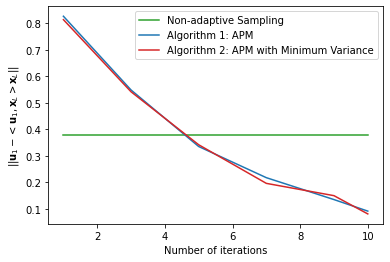

Fraction (%), budget: 10.0 1631353


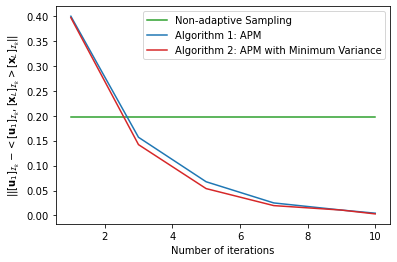

Fraction (%), budget: 10.0 1631353


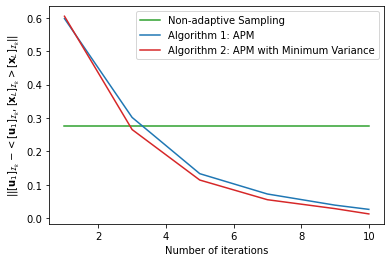

Number of sampled entries for APM: [1631731. 1584395. 1603549. 1586142. 1575274. 1549649.]
Number of sampled entries for APM2: [1631833. 1557249. 1577575. 1553657. 1558510. 1562848.]


In [35]:
#### '''Type 3 plot norm difference w.r.t. number of iterations given the budget (e.g., 40% missing edges)'''

sigrval_true, sigrvec_true = numpy_sigrs(A)
num_nodes = A.shape[1]
tot_samples = (num_nodes) ** 2 # number of nodes

'''Hyperparameters'''
frac = 0.1 # fix the available entries (unit: %)
k1 = 100 #top-k error plot
k2 = 500
num_trials = 1

'''Budget'''
# we multiply 0.5 since at the end we will make an estimated matrix symmetric
budget = math.ceil(frac * tot_samples)

# Using Numpy to create an array in x-axis

# num_iter_vec1 = np.array([1, 3, 5, 7, 9])
# num_iter_vec1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
# # num_iter_vec2 = np.array([10, 15, 20, 30, 40, 50])
# num_iter_vec2 = np.array([10, 11, 12, 13, 14, 15])
# num_iter_vec = np.concatenate((num_iter_vec1, num_iter_vec2))
num_iter_vec = np.array([1, 3, 5, 7, 9, 10])
num_iter = len(num_iter_vec)
idx_vec = np.arange(0, num_iter, 1)

err_NAS_mat = np.zeros((num_trials, num_iter))
err100_NAS_mat = np.zeros((num_trials, num_iter))
err500_NAS_mat = np.zeros((num_trials, num_iter))

err_AS_mat = np.zeros((num_trials, num_iter))
err100_AS_mat = np.zeros((num_trials, num_iter))
err500_AS_mat = np.zeros((num_trials, num_iter))
num_sample_mat = np.zeros((num_trials, num_iter))

err_AS2_mat = np.zeros((num_trials, num_iter))
err100_AS2_mat = np.zeros((num_trials, num_iter))
err500_AS2_mat = np.zeros((num_trials, num_iter))
num_sample2_mat = np.zeros((num_trials, num_iter))

# Assign variables to the y-axis part of the curve
for trial in np.arange(num_trials):
    sigrval_NAS, sigrvec_NAS, A_non_hat = non_adaptive_sampling(A, budget)
    err_NAS = compute_err(sigrvec_NAS, sigrvec_true, A)[1]
    
    err100_NAS = compute_topk_err(sigrvec_NAS, sigrvec_true, k1)
    err500_NAS = compute_topk_err(sigrvec_NAS, sigrvec_true, k2)
    for idx in idx_vec:
        err_NAS_mat[trial, idx] = err_NAS
        err100_NAS_mat[trial, idx] = err100_NAS
        err500_NAS_mat[trial, idx] = err500_NAS
    
    for idx in idx_vec:
        num_sample = 0
        '''APM'''
        adapt_samples, top_eig_adapt, A_hat, bias = APM(A, budget, num_iter_vec[idx])
        err_AS = compute_err(top_eig_adapt, sigrvec_true, A)[1]
        err_AS_mat[trial, idx] = err_AS        
        
        err100_AS = compute_topk_err(top_eig_adapt, sigrvec_true, k1)
        err100_AS_mat[trial, idx] = err100_AS
        err500_AS = compute_topk_err(top_eig_adapt, sigrvec_true, k2)
        err500_AS_mat[trial, idx] = err500_AS
        
        num_sample_mat[trial, idx] = adapt_samples
        print("Matrix estimation error of APM:", np.linalg.norm(A_hat - A))

        '''APM2'''
        adapt_samples2, top_eig_adapt2, A_hat2, bias2 = APM_minVar(A, budget, num_iter_vec[idx], 6000)

        err_AS2 = compute_err(top_eig_adapt2, sigrvec_true, A)[1]
        err_AS2_mat[trial, idx] = err_AS2
        
        err100_AS2 = compute_topk_err(top_eig_adapt2, sigrvec_true, k1)
        err100_AS2_mat[trial, idx] = err100_AS2
        err500_AS2 = compute_topk_err(top_eig_adapt2, sigrvec_true, k2)
        err500_AS2_mat[trial, idx] = err500_AS2
        
        num_sample2_mat[trial, idx] = adapt_samples2
        print("Matrix estimation error of APM2:", np.linalg.norm(A_hat2 - A))

        if idx == num_iter - 1:
            print("Top-100 eigenvector estimation error of APM:", err100_AS)
            print("Top-500 eigenvector estimation error of APM:", err500_AS)
            print("Sampling error of APM:", err_AS)
            print("Top-100 eigenvector estimation error of APM2:", err100_AS2)
            print("Top-500 eigenvector estimation error of APM2:", err500_AS2)
            print("Sampling error of APM2:", err_AS2)

            
#averaging over the number of trials
'''Method 1: Non-adaptive Sampling Power Method'''
mean_NAS_err_vec = np.mean((err_NAS_mat), axis = 0)
mean_NAS_err100_vec = np.mean((err100_NAS_mat), axis = 0)
mean_NAS_err500_vec = np.mean((err500_NAS_mat), axis = 0)
print("Top-100 non-adaptive sampling error:", mean_NAS_err100_vec[0])
print("Top-500 non-adaptive sampling error:", mean_NAS_err500_vec[0])
print("Non-adaptive sampling error:", mean_NAS_err_vec[0])

print("Number of sampled entries for non-adaptive sampling", budget)


'''Method 2: APM'''
'''Method 3: APM2'''
mean_err_vec = np.mean((err_AS_mat), axis = 0)
mean_err2_vec = np.mean((err_AS2_mat), axis = 0)

mean_num_sample_vec = np.ceil(np.mean(num_sample_mat, axis = 0))
mean_num_sample2_vec = np.ceil(np.mean(num_sample2_mat, axis = 0))

#averaging over the number of trials
'''Method 1: Non-adaptive Sampling Power Method'''

print("Number of sampled entries for non-adaptive sampling", budget)


'''Method 2: APM'''
'''Method 3: APM2'''
mean_err100_vec = np.mean((err100_AS_mat), axis = 0)
mean_err100_2_vec = np.mean((err100_AS2_mat), axis = 0)

mean_err500_vec = np.mean((err500_AS_mat), axis = 0)
mean_err500_2_vec = np.mean((err500_AS2_mat), axis = 0)

mean_num_sample_vec = np.ceil(np.mean(num_sample_mat, axis = 0))
mean_num_sample2_vec = np.ceil(np.mean(num_sample2_mat, axis = 0))    


# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err2_vec, color='tab:red', label='Algorithm 2: APM with Minimum Variance')
# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||\mathbf{u}_1 - <\mathbf{u}_1, \mathbf{x}_L>\mathbf{x}_L||$")
# plt.title("Top-{} Error plot with {}% budget".format(k, frac*100))
# plt.title("Error plot with {}% budget".format(frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_err.svg')
plt.show()

# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err100_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err100_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err100_2_vec, color='tab:red', label='Algorithm 2: APM with Minimum Variance')

# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||[\mathbf{u}_1]_{\mathcal{I}_k} - <[\mathbf{u}_1]_{\mathcal{I}_k}, [\mathbf{x}_L]_{\mathcal{I}_k}>[\mathbf{x}_L]_{\mathcal{I}_k}||$")
# plt.title("Top-{} Error plot with {}% budget".format(k1, frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_top100_err.svg')
plt.show()

# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err500_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err500_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err500_2_vec, color='tab:red', label='Algorithm 2: APM with Minimum Variance')

# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||[\mathbf{u}_1]_{\mathcal{I}_k} - <[\mathbf{u}_1]_{\mathcal{I}_k}, [\mathbf{x}_L]_{\mathcal{I}_k}>[\mathbf{x}_L]_{\mathcal{I}_k}||$")

# plt.title("Top-{} Error plot with {}% budget".format(k2, frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_top500_err.svg')
plt.show()

print("Number of sampled entries for APM:", mean_num_sample_vec)

print("Number of sampled entries for APM2:", mean_num_sample2_vec)

In [28]:
print(mean_NAS_err_vec)
print(mean_err_vec)
print(mean_err2_vec)

print(mean_NAS_err500_vec)
print(mean_err500_vec)
print(mean_err500_2_vec)

[0.55914516 0.55914516 0.55914516 0.55914516 0.55914516 0.55914516]
[0.83706641 0.55281489 0.43192918 0.35958507 0.25176104 0.26448456]
[0.87244198 0.58200518 0.33628622 0.16327875 0.10622708 0.11594117]
[0.37812199 0.37812199 0.37812199 0.37812199 0.37812199 0.37812199]
[0.63461596 0.32532875 0.27311227 0.27105823 0.16468303 0.17128924]
[0.69204137 0.31060348 0.13158316 0.04895935 0.0376725  0.03302377]


In [30]:
'''Performance improvement of APM over the non-adaptive scheme'''
print((mean_NAS_err_vec[4] - mean_err_vec[4])/mean_NAS_err_vec[4]*100)

54.97393989467181


In [31]:
'''Performance improvement of APM_minVar over the non-adaptive scheme'''
print((mean_NAS_err_vec[4] - mean_err2_vec[4])/mean_NAS_err_vec[4]*100)

81.00187859834786


In [32]:
'''Performance improvement of APM_minVar over APM'''
print((mean_err_vec[4] - mean_err2_vec[4])/mean_err_vec[4]*100)

57.806387329447915


In [33]:
'''Top500 l2 error: Performance improvement of APM and APM_minVar over the non-adative scheme'''
print((mean_NAS_err500_vec[4] - mean_err500_vec[4])/mean_NAS_err500_vec[4]*100)
print((mean_NAS_err500_vec[4] - mean_err500_2_vec[4])/mean_NAS_err500_vec[4]*100)

56.44711790260205
90.0369442312095


In [34]:
'''Top500 l2 error: Performance improvement of APM_minVar over APM'''
print((mean_err500_vec[4] - mean_err500_2_vec[4])/mean_err500_vec[4]*100)

77.12423314142572


In [ ]:
print(err_NAS)
print(err_AS)
print(err_AS2)

print("improvement:", (err_NAS-err_AS)/err_NAS*100)
print("improvement:", (err_NAS-err_AS2)/err_NAS*100)


print(err100_NAS)
print(err100_AS)
print(err100_AS2)

print("improvement:", (err100_NAS-err100_AS)/err100_NAS*100)
print("improvement:", (err100_NAS-err100_AS2)/err100_NAS*100)

print(err500_NAS)
print(err500_AS)
print(err500_AS2)

print("improvement:", (err500_NAS-err500_AS)/err500_NAS*100)
print("improvement:", (err500_NAS-err500_AS2)/err500_NAS*100)

Fraction (%), budget: 50.0 9103645


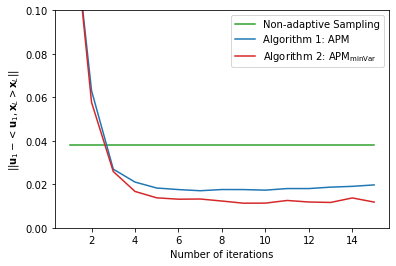

Fraction (%), budget: 50.0 9103645


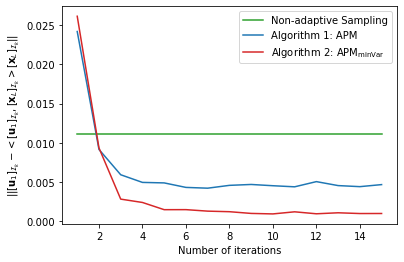

Fraction (%), budget: 50.0 9103645


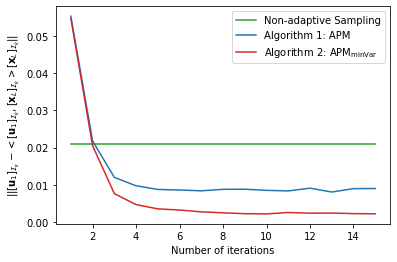

Number of sampled entries for APM: [8203681. 8528019. 8819021. 8969917. 9036424. 9075288. 9088157. 9092608.
 9096560. 9105227. 9101235. 9101776. 9103370. 9098963. 9102176.]
Number of sampled entries for APM2: [8298524. 8523647. 8614903. 8743119. 8858239. 8942070. 8992621. 9027590.
 9052072. 9069300. 9079582. 9086929. 9092806. 9091324. 9097697.]


In [25]:
# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err2_vec, color='tab:red', label='Algorithm 2: APM$_{\min\mathrm{Var}}$')
# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||\mathbf{u}_1 - <\mathbf{u}_1, \mathbf{x}_L>\mathbf{x}_L||$")
# plt.title("Top-{} Error plot with {}% budget".format(k, frac*100))
# plt.title("Error plot with {}% budget".format(frac*100))

plt.ylim([0, 15])
plt.ylim([0, 0.1])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_err.svg')
plt.show()

# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err100_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err100_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err100_2_vec, color='tab:red', label='Algorithm 2: APM$_{\min\mathrm{Var}}$')

# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||[\mathbf{u}_1]_{\mathcal{I}_k} - <[\mathbf{u}_1]_{\mathcal{I}_k}, [\mathbf{x}_L]_{\mathcal{I}_k}>[\mathbf{x}_L]_{\mathcal{I}_k}||$")
# plt.title("Top-{} Error with {}% budget".format(k1, frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_top100_err.svg')
plt.show()

# Plotting both the curves simultaneously
print("Fraction (%), budget:", frac*100, budget)
plt.plot(num_iter_vec, mean_NAS_err500_vec, color='tab:green', label='Non-adaptive Sampling')

plt.plot(num_iter_vec, mean_err500_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(num_iter_vec, mean_err500_2_vec, color='tab:red', label='Algorithm 2: APM$_{\min\mathrm{Var}}$')

# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||[\mathbf{u}_1]_{\mathcal{I}_k} - <[\mathbf{u}_1]_{\mathcal{I}_k}, [\mathbf{x}_L]_{\mathcal{I}_k}>[\mathbf{x}_L]_{\mathcal{I}_k}||$")
# plt.title("Top-{} Error with {}% budget".format(k2, frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_top500_err.svg')
plt.show()

print("Number of sampled entries for APM:", mean_num_sample_vec)

print("Number of sampled entries for APM2:", mean_num_sample2_vec)

In [102]:
'''Save as a csv file'''
ddi_eig_est_err = np.vstack((num_iter_vec, mean_NAS_err_vec, mean_err_vec, mean_err2_vec))
ddi_eig_est_top100_err = np.vstack((num_iter_vec, mean_NAS_err100_vec, mean_err100_vec, mean_err100_2_vec))
ddi_eig_est_top500_err = np.vstack((num_iter_vec, mean_NAS_err500_vec, mean_err500_vec, mean_err500_2_vec))

np.savetxt("ddi_eig_est_err.csv", ddi_eig_est_err, delimiter=",")
np.savetxt("ddi_eig_est_top100_err.csv", ddi_eig_est_top100_err, delimiter=",")
np.savetxt("ddi_eig_est_top500_err.csv", ddi_eig_est_top500_err, delimiter=",")

[[1.00000000e+00 2.00000000e+00 3.00000000e+00 4.00000000e+00
  5.00000000e+00 6.00000000e+00 7.00000000e+00 8.00000000e+00
  9.00000000e+00 1.00000000e+01 1.10000000e+01 1.20000000e+01
  1.30000000e+01 1.40000000e+01 1.50000000e+01]
 [3.79342041e-02 3.79342041e-02 3.79342041e-02 3.79342041e-02
  3.79342041e-02 3.79342041e-02 3.79342041e-02 3.79342041e-02
  3.79342041e-02 3.79342041e-02 3.79342041e-02 3.79342041e-02
  3.79342041e-02 3.79342041e-02 3.79342041e-02]
 [1.54851061e-01 6.30933227e-02 2.69665747e-02 2.10307483e-02
  1.82943293e-02 1.75803071e-02 1.70483255e-02 1.76000987e-02
  1.75790755e-02 1.73122188e-02 1.80481464e-02 1.80476235e-02
  1.86997317e-02 1.90633683e-02 1.97266963e-02]
 [1.57840161e-01 5.77151262e-02 2.58852388e-02 1.67183944e-02
  1.37758496e-02 1.31543041e-02 1.32398151e-02 1.23063114e-02
  1.13087084e-02 1.13567377e-02 1.25684057e-02 1.18594480e-02
  1.16614709e-02 1.37350381e-02 1.18255464e-02]]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
F

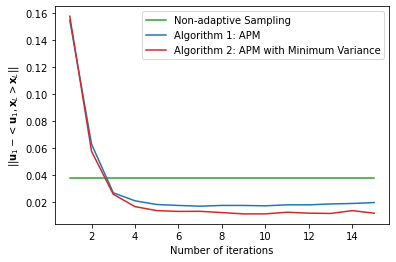

In [132]:
'''Read the csv file to reconstruct the plot'''
x = []
y = []
z = []
w = []
  
with open('ddi_eig_est_err.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    plots_iter = iter(plots)
    x = next(plots_iter)
    x = [int(float(num)) for num in x]
    y = next(plots_iter)
    y = [float(num) for num in y]
    z = next(plots_iter)
    z = [float(num) for num in z]
    w = next(plots_iter)
    w = [float(num) for num in w]

my_data = genfromtxt('ddi_eig_est_err.csv', delimiter=',')
print(my_data)
print(my_data[0])
    
print("Fraction (%), budget:", frac*100, budget)
plt.plot(my_data[0], my_data[1], color='tab:green', label='Non-adaptive Sampling')

plt.plot(x, z, color='tab:blue', label='Algorithm 1: APM')
plt.plot(x, w, color='tab:red', label='Algorithm 2: APM with Minimum Variance')
# Naming the x-axis, y-axis and set the title
plt.xlabel("Number of iterations")
plt.ylabel("$||\mathbf{u}_1 - <\mathbf{u}_1, \mathbf{x}_L>\mathbf{x}_L||$")
# plt.title("Top-{} Error plot with {}% budget".format(k, frac*100))
# plt.title("Error plot with {}% budget".format(frac*100))

# plt.ylim([0, 0.15])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_eig_estimation_err.svg')
plt.show()

[8.32732040e-03 1.62702467e-03 2.05851617e-05 ... 1.76299214e-06
 5.02971816e-04 3.97413675e-04]


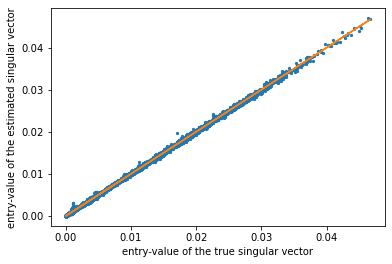

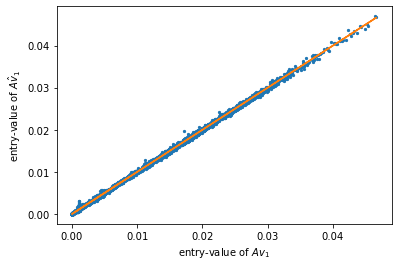

In [22]:
'''Scatter plot for the estimated singular vector and the true one.
    If they are the same, the plot has to be aligned with the function "y=x."'''

'''True top-singular vector and top-singlular value '''
sigrval_true, sigrvec_true = numpy_sigrs(A)

'''Hyperparameters'''
num_iter = 5 #fix the number of iterations
frac = 0.5 # fix the available entries (unit: %)

'''Budget'''
# we multiply 0.5 since at the end we will make an estimated matrix symmetric
num_nodes = A.shape[1]
tot_samples = (num_nodes) ** 2 # number of nodes
budget = math.ceil(frac * tot_samples)

adapt_samples, top_eig_adapt, A_hat, bias = APM(A, budget, num_iter)
print(top_eig_adapt)

'''Scatter plot for v and \hat{v}'''
plt.scatter(np.absolute(sigrvec_true),  np.absolute(top_eig_adapt), color ='tab:blue', s = 5)
plt.plot(np.absolute(sigrvec_true), np.absolute(sigrvec_true), color='tab:orange')
  
# Naming the x-axis, y-axis and set the title
plt.xlabel("entry-value of the true singular vector")
plt.ylabel("entry-value of the estimated singular vector")
# plt.title("Efficiency")
# plt.xlim([0, 0.05])
# plt.ylim([0, 0.05])
  
# Adding legend, which helps us recognize the curve according to it's color
# plt.legend(loc = 'lower right')
  
# display the plot
plt.show()

'''Scatter plot for A*v and A*\hat{v}'''
plt.scatter(np.absolute(sigrvec_true),  np.absolute(top_eig_adapt), color ='tab:blue', s = 5)
plt.plot(np.absolute(sigrvec_true), np.absolute(sigrvec_true), color='tab:orange')
  
# Naming the x-axis, y-axis and set the title
plt.xlabel("entry-value of $Av_1$")
plt.ylabel("entry-value of $A\hat{v}_1$")
# plt.title("Efficiency")
# plt.xlim([0, 0.05])
# plt.ylim([0, 0.05])
  
# Adding legend, which helps us recognize the curve according to it's color
# plt.legend(loc = 'lower right')
  
# display the plot
plt.show()

/var/folders/9d/gnml6k613yvdls_n8jsql6g80000gn/T/ipykernel_74430/2806021529.py:49: RuntimeWarning: invalid value encountered in double_scalars
  cosine1 = np.dot(topk_eigvec, topk_eigvec_true)/(np.linalg.norm(topk_eigvec)*np.linalg.norm(topk_eigvec_true))
/var/folders/9d/gnml6k613yvdls_n8jsql6g80000gn/T/ipykernel_74430/2806021529.py:50: RuntimeWarning: invalid value encountered in double_scalars
  cosine2 = np.dot(topk_eigvec_flip, topk_eigvec_true)/(np.linalg.norm(topk_eigvec_flip)*np.linalg.norm(topk_eigvec_true))


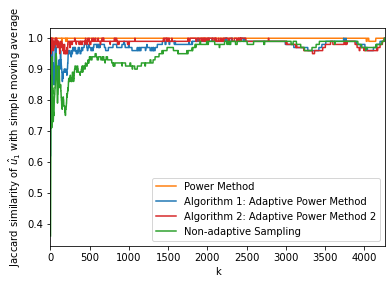

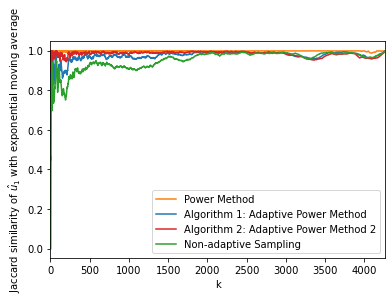

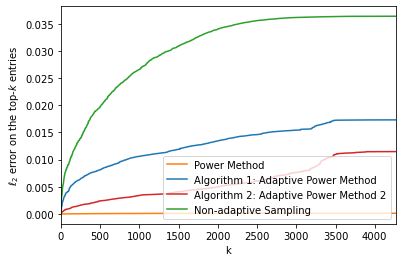

In [22]:
'''Computing Jaccard Similarity for Top-k Entries of the Top-singular vector'''

'''True top eigenvector and top singlular value '''
sigrval_true, sigrvec_true = numpy_sigrs(A)
num_nodes = A.shape[1]
tot_samples = (num_nodes) ** 2 # number of nodes

'''Hyperparameters'''
num_iter = 10 #fix the number of iterations
frac = 0.5 # fix the available entries (unit: %)
# boost_const = 50

'''Budget'''
# we multiply 0.5 since at the end we will make an estimated matrix symmetric
budget = math.ceil(frac * tot_samples)

adapt_samples, top_eig_adapt, A_hat, bias = APM(A, budget, num_iter)
adapt_samples2, top_eig_adapt2, A_hat2, bias2 = APM_minVar(A, budget, num_iter, 6000)
sigrval_NAS, sigrvec_NAS, A_non_hat = non_adaptive_sampling(A, int(adapt_samples))
sigrval_PM, sigrvec_PM = basic_PM(A, 10)

# Using Numpy to create an array in x-axis
k_vec = np.arange(num_nodes)
k_vec = [k+1 for k in k_vec]
jaccard_PM_vec = np.zeros(num_nodes)
jaccard_AS_vec = np.zeros(num_nodes)
jaccard_AS2_vec = np.zeros(num_nodes)
jaccard_NAS_vec = np.zeros(num_nodes)

l2_PM_vec = np.zeros(num_nodes)
l2_AS_vec = np.zeros(num_nodes)
l2_AS2_vec = np.zeros(num_nodes)
l2_NAS_vec = np.zeros(num_nodes)

# Assign variables to the y-axis part of the curve
for k in k_vec:
    s = k-1
    idx_true = topk_sigrs_calc(sigrvec_true, k)[1]
    
    '''Method 1: APM'''
    idx_AS = topk_sigrs_calc(top_eig_adapt, k)[1]
    jaccard_AS_vec[s] = jaccard_similarity(idx_AS, idx_true)
    
    l2_AS_vec[s] = compute_topk_err(top_eig_adapt, sigrvec_true, s)
    
    '''Method 2: APM_minVar'''
    idx_AS2 = topk_sigrs_calc(top_eig_adapt2, k)[1]
    jaccard_AS2_vec[s] = jaccard_similarity(idx_AS2, idx_true)
    
    l2_AS2_vec[s] = compute_topk_err(top_eig_adapt2, sigrvec_true, s)
    
    '''Method 3: Non-adaptive Sampling Power Method'''
    idx_NAS = topk_sigrs_calc(sigrvec_NAS, k)[1]
    jaccard_NAS_vec[s] = jaccard_similarity(idx_NAS, idx_true)
    
    l2_NAS_vec[s] = compute_topk_err(sigrvec_NAS, sigrvec_true, s)
    
    '''Method 4: Basic Power Method'''
    idx_PM = topk_sigrs_calc(sigrvec_PM, k)[1]
    jaccard_PM_vec[s] = jaccard_similarity(idx_PM, idx_true)
    
    l2_PM_vec[s] = compute_topk_err(sigrvec_PM, sigrvec_true, s)

'''Plot Jaccard similarity with simple moving average'''
window_size = 4    
moving_avg_PM = moving_average(jaccard_PM_vec, window_size)
moving_avg_AS = moving_average(jaccard_AS_vec, window_size)
moving_avg_AS2 = moving_average(jaccard_AS2_vec, window_size)
moving_avg_NAS = moving_average(jaccard_NAS_vec, window_size)
                         
k_vec_simple = k_vec[:num_nodes- window_size + 1]

# Plotting both the curves simultaneously importing moving-averages
plt.plot(k_vec_simple, moving_avg_PM, color='tab:orange', label='Power Method')
plt.plot(k_vec_simple, moving_avg_AS, color='tab:blue', label='Algorithm 1: Adaptive Power Method')
plt.plot(k_vec_simple, moving_avg_AS2, color='tab:red', label='Algorithm 2: Adaptive Power Method 2')
plt.plot(k_vec_simple, moving_avg_NAS, color='tab:green', label='Non-adaptive Sampling')

  
# Naming the x-axis, y-axis and set the title
plt.xlabel("k")
plt.ylabel("Jaccard similarity of $\hat{u}_1$ with simple moving average")
# plt.title("Efficiency")
plt.xlim([0, num_nodes])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'lower right')
  
# display the plot
plt.savefig('ddi_jaccard_similarity_simple.svg')
plt.show()

'''Plot Jaccard similarity with exponential moving average'''
exp_moving_avg_PM = exp_moving_average(jaccard_PM_vec, window_size)
exp_moving_avg_AS = exp_moving_average(jaccard_AS_vec, window_size)
exp_moving_avg_AS2 = exp_moving_average(jaccard_AS2_vec, window_size)
exp_moving_avg_NAS = exp_moving_average(jaccard_NAS_vec, window_size)
    

# Plotting both the curves simultaneously
plt.plot(k_vec, exp_moving_avg_PM, color='tab:orange', label='Power Method')
plt.plot(k_vec, exp_moving_avg_AS, color='tab:blue', label='Algorithm 1: Adaptive Power Method')
plt.plot(k_vec, exp_moving_avg_AS2, color='tab:red', label='Algorithm 2: Adaptive Power Method 2')
plt.plot(k_vec, exp_moving_avg_NAS, color='tab:green', label='Non-adaptive Sampling')
  
# Naming the x-axis, y-axis and set the title
plt.xlabel("k")
plt.ylabel("Jaccard similarity of $\hat{u}_1$ with exponential moving average")
# plt.title("Efficiency")
plt.xlim([0, num_nodes])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'lower right')
  
# display the plot
plt.savefig('ddi_jaccard_similarity_exp.svg')
plt.show()

'''Plot l2 error over top-k entries'''
# Plotting both the curves simultaneously
plt.plot(k_vec, l2_PM_vec, color='tab:orange', label='Power Method')
plt.plot(k_vec, l2_AS_vec, color='tab:blue', label='Algorithm 1: Adaptive Power Method')
plt.plot(k_vec, l2_AS2_vec, color='tab:red', label='Algorithm 2: Adaptive Power Method 2')
plt.plot(k_vec, l2_NAS_vec, color='tab:green', label='Non-adaptive Sampling')


# Naming the x-axis, y-axis and set the title
plt.xlabel("k")
plt.ylabel("$\ell_2$ error on the top-$k$ entries")
# plt.title("Efficiency")
plt.xlim([0, num_nodes])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'lower right')
  
# display the plot
plt.savefig('ddi_l2err_over_k.svg')
plt.show()

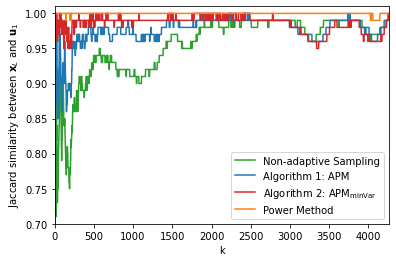

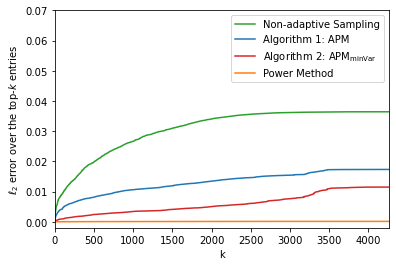

In [23]:
window_size = 4    
moving_avg_PM = moving_average(jaccard_PM_vec, window_size)
moving_avg_AS = moving_average(jaccard_AS_vec, window_size)
moving_avg_AS2 = moving_average(jaccard_AS2_vec, window_size)
moving_avg_NAS = moving_average(jaccard_NAS_vec, window_size)
                         
k_vec_simple = k_vec[:num_nodes- window_size + 1]
# Plotting both the curves simultaneously importing moving-averages
plt.plot(k_vec_simple, moving_avg_NAS, color='tab:green', label='Non-adaptive Sampling')
plt.plot(k_vec_simple, moving_avg_AS, color='tab:blue', label='Algorithm 1: APM')
plt.plot(k_vec_simple, moving_avg_AS2, color='tab:red', label='Algorithm 2: APM$_{\min\mathrm{Var}}$')
plt.plot(k_vec_simple, moving_avg_PM, color='tab:orange', label='Power Method')


  
# Naming the x-axis, y-axis and set the title
plt.xlabel("k")
plt.ylabel("Jaccard similarity between $\mathbf{x}_L$ and $\mathbf{u}_1$")
# plt.title("Efficiency")
plt.xlim([0, num_nodes])
plt.ylim([0.7, 1.01])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'lower right')
  
# display the plot
plt.savefig('ddi_jaccard_similarity.svg')
plt.show()

# Plotting both the curves simultaneously
plt.plot(k_vec, l2_NAS_vec, color='tab:green', label='Non-adaptive Sampling')
plt.plot(k_vec, l2_AS_vec, color='tab:blue', label='Algorithm 1: APM')
plt.plot(k_vec, l2_AS2_vec, color='tab:red', label='Algorithm 2: APM$_{\min\mathrm{Var}}$')
plt.plot(k_vec, l2_PM_vec, color='tab:orange', label='Power Method')


# Naming the x-axis, y-axis and set the title
plt.xlabel("k")
plt.ylabel("$\ell_2$ error over the top-$k$ entries")
# plt.title("Efficiency")
plt.xlim([0, num_nodes])
plt.ylim([-0.002, 0.07])

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
  
# display the plot
plt.savefig('ddi_l2err_over_k.svg')
plt.show()

In [71]:
'''Save as a csv file'''
ddi_jaccard_simple = np.vstack((k_vec_simple, moving_avg_NAS, moving_avg_AS, moving_avg_AS2, moving_avg_PM))
ddi_jaccard_exp = np.vstack((k_vec, exp_moving_avg_NAS, exp_moving_avg_AS, exp_moving_avg_AS2, exp_moving_avg_PM))
ddi_l2_err = np.vstack((k_vec, l2_PM_vec, l2_AS_vec, l2_AS2_vec, l2_NAS_vec))

np.savetxt("ddi_jaccard_simple.csv", ddi_jaccard_simple, delimiter=",")
np.savetxt("ddi_jaccard_exp.csv", ddi_jaccard_exp, delimiter=",")
np.savetxt("ddi_l2_err.csv", ddi_l2_err, delimiter=",")